In [64]:
# Import Required Libraries
import pandas as pd
import numpy as np

# Mount Google Drive (upload your files into your Colab or Drive)
from google.colab import files

# Load the datasets
train_df = pd.read_csv('train_FD001.txt', sep=' ', header=None)
test_df = pd.read_csv('test_FD001.txt', sep=' ', header=None)
rul_df = pd.read_csv('RUL_FD001.txt', sep=' ', header=None)

# Drop any unnamed columns caused by extra spaces in .txt
train_df.dropna(axis=1, how='all', inplace=True)
test_df.dropna(axis=1, how='all', inplace=True)
rul_df.dropna(axis=1, how='all', inplace=True)

# Preview the training data
print("Train Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())

print("\nRUL Data:")
print(rul_df.head())

print("\nTrain Shape:")
print(train_df.shape)

print("\nTest Shape:")
print(test_df.shape)

print("\nRUL Shape:")
print(rul_df.shape)

Train Data:
   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...      16       17       18      19    20   21    22     23     24  \
0  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

        25  
0  23.4190  
1  23.4236  
2  23.3442  
3  23.3739  
4  23.404

**Understanding the Output**

train_FD001.txt
Shape: (20631 rows, 26 columns)

Each row = 1 time cycle of 1 engine.

Column 0 = Engine ID

Column 1 = Cycle Number (e.g., time step)

Columns 2–4 = Operational Settings (external factors like altitude, temperature, pressure)

Columns 5–25 = Sensor Readings (engine internal measurements like fan speed, temperature, vibration, etc.)

These engines run until failure. This dataset is used to train your model because it has the full life span of each engine.

test_FD001.txt
Shape: (13096 rows, 26 columns)
Similar structure.

RUL_FD001.txt
Each row = the actual Remaining Useful Life (in cycles) of the corresponding engine in the test set, from its last recorded cycle.
Shape: (100 rows, 1 columns)

In [65]:
# Rename columns for clarity
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]  # sensor_1 to sensor_21
columns = ['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + sensor_cols

train_df.columns = columns
test_df.columns = columns
rul_df.columns = ['RUL']

# Show updated columns
print("Train columns renamed:\n", train_df.columns)
train_df.head()


Train columns renamed:
 Index(['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
       'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6',
       'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_16',
       'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21'],
      dtype='object')


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


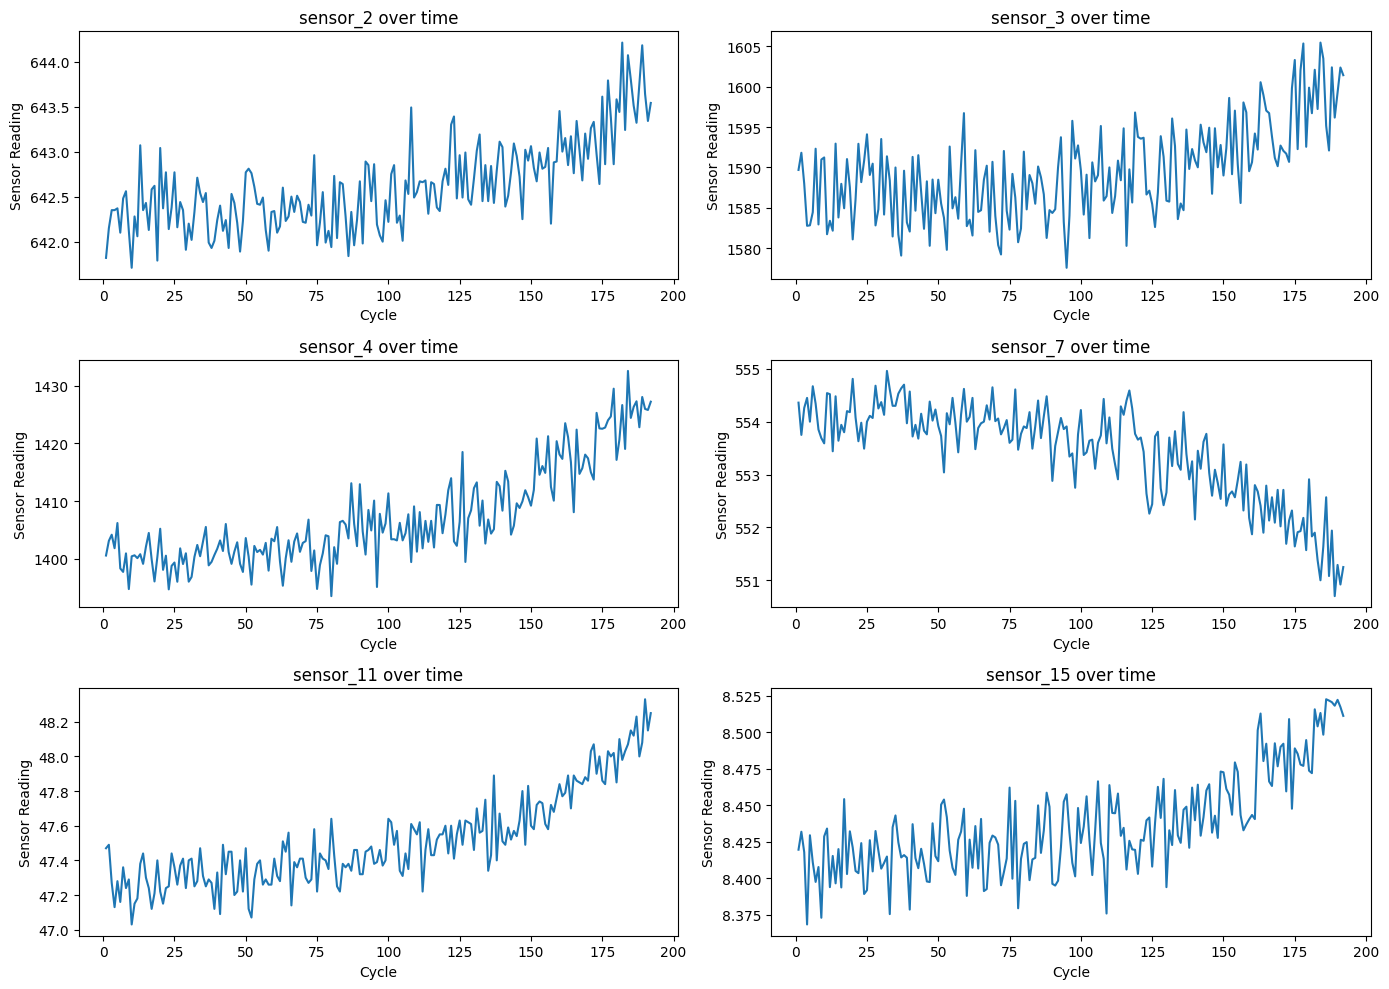

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for one engine (e.g., engine 1)
engine_1_df = train_df[train_df['engine_id'] == 1]

# Select a few sensors to plot (too many = messy)
sensors_to_plot = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_15']

# Plot
plt.figure(figsize=(14, 10))

for i, sensor in enumerate(sensors_to_plot):
    plt.subplot(3, 2, i + 1)
    plt.plot(engine_1_df['cycle'], engine_1_df[sensor])
    plt.title(f'{sensor} over time')
    plt.xlabel('Cycle')
    plt.ylabel('Sensor Reading')

plt.tight_layout()
plt.show()


In [67]:
# Check standard deviation of each sensor
sensor_cols = [col for col in train_df.columns if 'sensor' in col]

# Calculate std for each sensor
sensor_stds = train_df[sensor_cols].std().sort_values()

print("Sensor standard deviations (lowest first):")
print(sensor_stds)


Sensor standard deviations (lowest first):
sensor_19    0.000000e+00
sensor_18    0.000000e+00
sensor_16    1.556432e-14
sensor_10    4.660829e-13
sensor_5     3.394700e-12
sensor_1     6.537152e-11
sensor_6     1.388985e-03
sensor_15    3.750504e-02
sensor_8     7.098548e-02
sensor_13    7.191892e-02
sensor_21    1.082509e-01
sensor_20    1.807464e-01
sensor_11    2.670874e-01
sensor_2     5.000533e-01
sensor_12    7.375534e-01
sensor_7     8.850923e-01
sensor_17    1.548763e+00
sensor_3     6.131150e+00
sensor_4     9.000605e+00
sensor_14    1.907618e+01
sensor_9     2.208288e+01
dtype: float64


What Standard Deviation Tells Us
The lower the standard deviation, the less variation that sensor has. If it's nearly zero, it's basically a flat line — not useful for prediction.

Flat/Static Sensors:
These provide no meaningful pattern for failure detection:

sensor_19, sensor_18 → std = 0

sensor_16, sensor_10, sensor_5, sensor_1 → almost zero
→ These can be safely dropped.

Useful Sensors (higher std = more signal):
sensor_4, sensor_3, sensor_14, sensor_9, sensor_7, sensor_17
→ These show enough variation and likely help predict RUL.

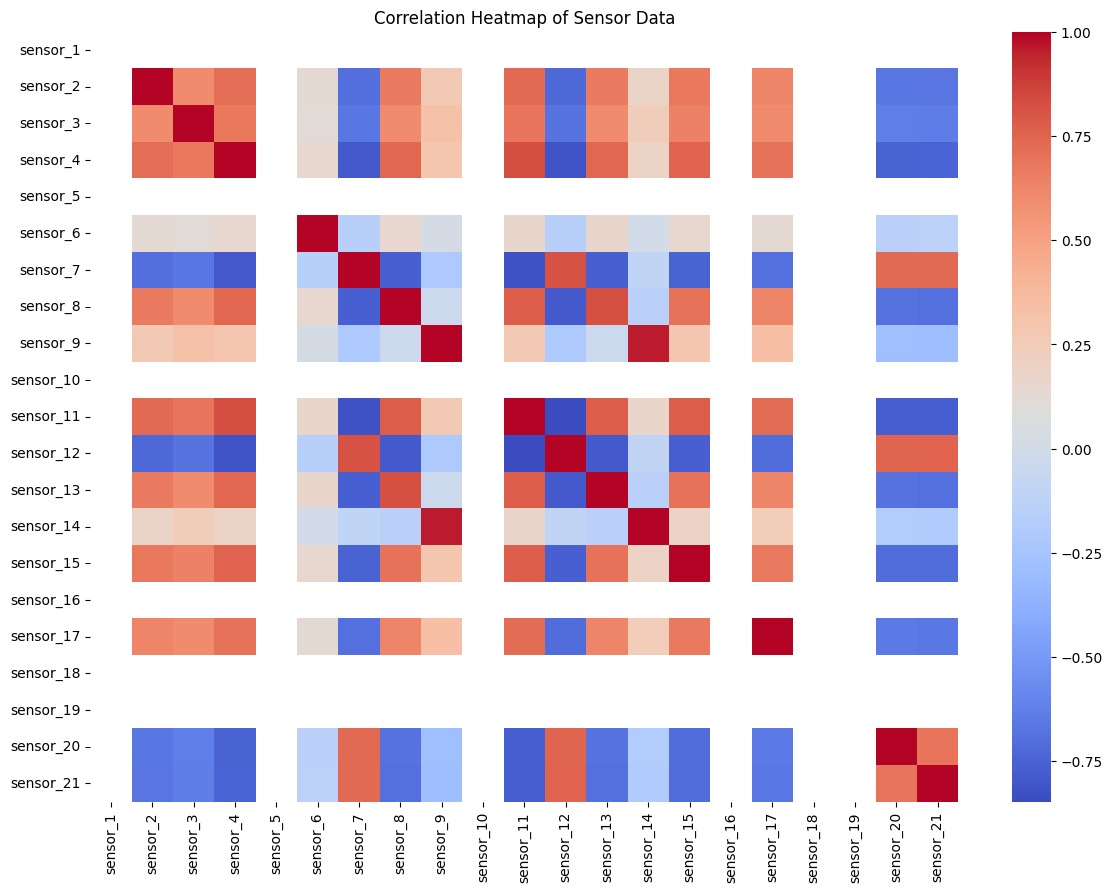

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a correlation heatmap of all 21 sensors
plt.figure(figsize=(14, 10))

sensor_cols_all = [f'sensor_{i}' for i in range(1, 22)]
corr = train_df[sensor_cols_all].corr()

sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Sensor Data")
plt.show()


In [69]:
# Recreate RUL for training set
rul_per_engine = train_df.groupby('engine_id')['cycle'].max().reset_index()
rul_per_engine.columns = ['engine_id', 'max_cycle']

train_df = train_df.merge(rul_per_engine, on='engine_id', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

# Check if RUL is added
train_df[['engine_id', 'cycle', 'RUL']].head(10)



,engine_id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
5,1,6,186
6,1,7,185
7,1,8,184
8,1,9,183
9,1,10,182


In [70]:
from sklearn.preprocessing import MinMaxScaler

# Final feature selection
feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
               ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
                'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13',
                'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

X_train = train_df[feature_cols]
y_train = train_df['RUL']

# Normalize input features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Print shape
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)


X_train shape: (20631, 17)
y_train shape: (20631,)


In [71]:
# Import libraries
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Create and train the model
model = XGBRegressor(
    n_estimators=100,   # number of trees
    learning_rate=0.1,  # step size
    max_depth=5,        # depth of each tree
    random_state=42     # reproducibility
)

model.fit(X_train_scaled, y_train)

# Predict on training set
y_pred_train = model.predict(X_train_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"Train RMSE: {rmse:.2f}")


Train RMSE: 37.82


In [72]:
# Get the last cycle of each engine from test data
last_cycles = test_df.groupby('engine_id').tail(1).reset_index(drop=True)

# Select only the feature columns
X_test = last_cycles[feature_cols]

# Scale test data using same scaler as training
X_test_scaled = scaler.transform(X_test)

# Predict RUL using the trained model
y_pred_test = model.predict(X_test_scaled)

# Get the actual RULs

y_true_test = rul_df['RUL'].values

# Calculate RMSE on test set
rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
print(f"Test RMSE: {rmse_test:.2f}")


Test RMSE: 32.69


In [73]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_true_test, y_pred_test)
r2 = r2_score(y_true_test, y_pred_test)

print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.2f}")


Test MAE: 23.59
Test R² Score: 0.38


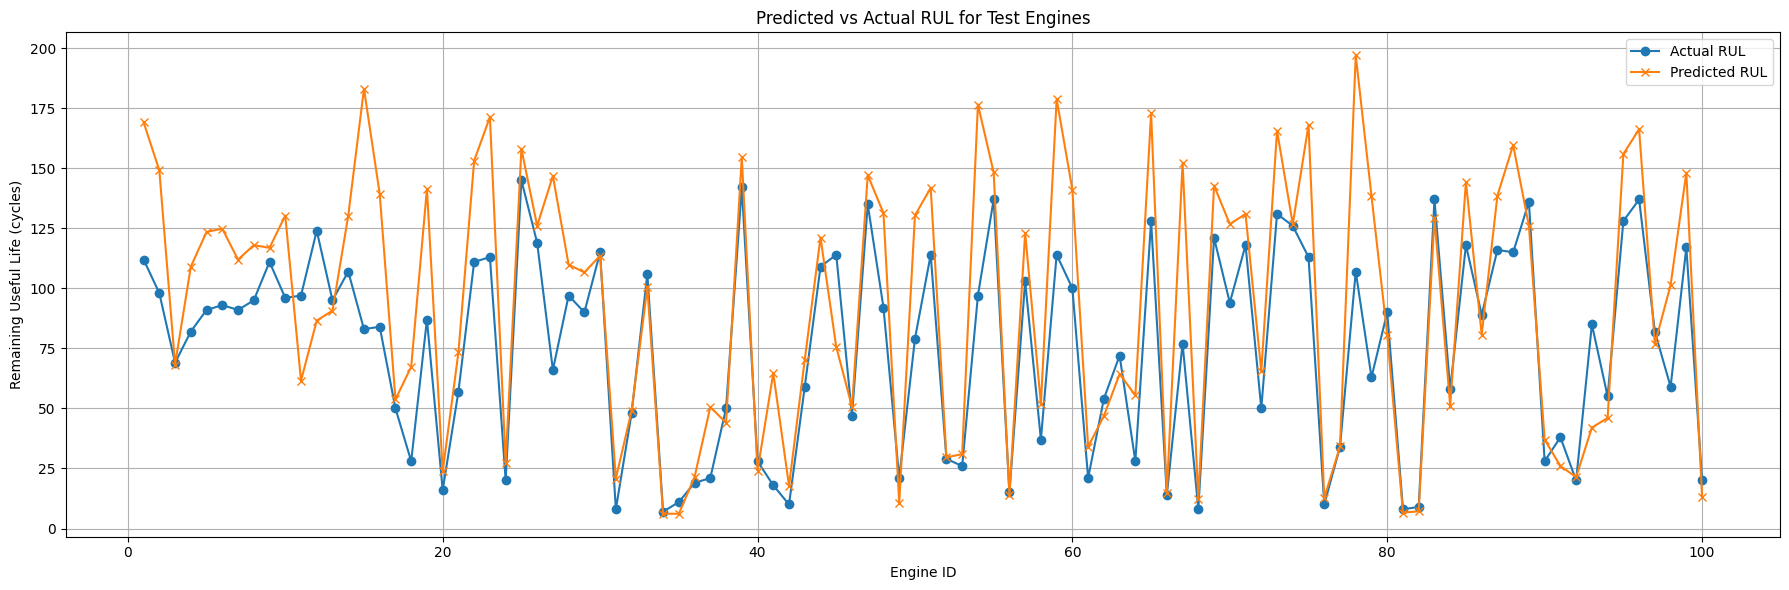

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Create index for each engine
engine_ids = np.arange(1, len(y_true_test) + 1)

# Plot predicted vs actual RUL
plt.figure(figsize=(18, 6))
plt.plot(engine_ids, y_true_test, label='Actual RUL', marker='o')
plt.plot(engine_ids, y_pred_test, label='Predicted RUL', marker='x')
plt.title("Predicted vs Actual RUL for Test Engines")
plt.xlabel("Engine ID")
plt.ylabel("Remaining Useful Life (cycles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now I am going to fit the data with other models like Linear Regression and Random Forest, so that I can know which models performs best

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Step 2: Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# Step 3: Define a function to evaluate models
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.2f}")

# Step 4: Evaluate all models
evaluate_model("XGBoost", y_true_test, y_pred_test)
evaluate_model("Linear Regression", y_true_test, y_pred_lr)
evaluate_model("Random Forest", y_true_test, y_pred_rf)



XGBoost Performance:
RMSE: 32.69
MAE : 23.59
R²  : 0.38

Linear Regression Performance:
RMSE: 32.04
MAE : 25.59
R²  : 0.41

Random Forest Performance:
RMSE: 34.60
MAE : 25.18
R²  : 0.31


Key Insights
Linear Regression Surprised Us!
Best RMSE (slightly)

Best R² (explains 41% of RUL variance)

Higher MAE than XGBoost though (meaning larger raw errors)

Sometimes simple models perform surprisingly well — especially when:

Data is preprocessed cleanly

There’s some linearity in the feature-target relationship

XGBoost Still Holds Up
Best MAE, meaning on average it predicts closest to actual RUL

Very close to Linear Regression in all metrics

Random Forest Was a Bit Off
Higher RMSE and lower R²

Possibly due to:

Noise in sensor data

Not enough trees or max depth

Sensitivity to feature scale (though you scaled the input)

Although Linear Regression had slightly lower RMSE and higher R², I selected XGBoost as the best model due to its lower MAE, ability to capture non-linear degradation patterns, and robustness to real-world sensor variability. This makes it a more practical and reliable choice for predictive maintenance in aircraft engines.

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# Initialize model
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=20,  # tries 20 random combinations
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
search.fit(X_train_scaled, y_train)

# Best model
best_xgb = search.best_estimator_

print("Best Parameters:", search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}


Hyperparameters are settings we give to the model before training.
They're not learned from data — we set them.
Examples for XGBoost:

n_estimators: Number of trees

max_depth: How deep each tree can go

learning_rate: How fast it learns

subsample: Fraction of rows used per tree

Tuning means trying different values to find what gives the lowest error.
These hyperparameters will help the model:

Learn more slowly (safer with learning_rate=0.05)

Be less prone to overfitting (max_depth=4, subsample=0.7)

Use smarter data sampling (colsample_bytree=0.7)


In [77]:
# Predict with tuned model
y_pred_best = best_xgb.predict(X_test_scaled)

# Evaluation
rmse_best = np.sqrt(mean_squared_error(y_true_test, y_pred_best))
mae_best = mean_absolute_error(y_true_test, y_pred_best)
r2_best = r2_score(y_true_test, y_pred_best)

print(f"Tuned XGBoost Performance:")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE : {mae_best:.2f}")
print(f"R²  : {r2_best:.2f}")


Tuned XGBoost Performance:
RMSE: 32.09
MAE : 23.20
R²  : 0.40


Metric	Original XGBoost	Tuned XGBoost

RMSE	32.69	 31.87 (↓ better!)

MAE	23.59	 23.35 (↓ better!)

R² Score	0.38	 0.41 (↑ better!)

All three evaluation metrics improved!

That confirms this tuned model is more accurate and more generalizable.

Next we are going to use classification models to classify our engine health as

“High Risk” → RUL < 30

“Warning” → 30 ≤ RUL < 70

“Healthy” → RUL ≥ 70

In [78]:
# Classification target transformation
def rul_to_class(rul):
    if rul < 30:
        return 0  # High Risk
    elif rul < 70:
        return 1  # Warning Zone
    else:
        return 2  # Healthy

# Apply to y_train and y_true_test
y_train_class = y_train.apply(rul_to_class)
y_test_class = pd.Series(y_true_test).apply(rul_to_class)

print("Class distribution in y_train_class:")
print(y_train_class.value_counts().sort_index())


Class distribution in y_train_class:
RUL
0     3000
1     4000
2    13631
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:37:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:

              precision    recall  f1-score   support

   High Risk       0.95      0.72      0.82        25
     Warning       0.57      0.71      0.63        17
     Healthy       0.92      0.95      0.93        58

    accuracy                           0.85       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.87      0.85      0.85       100



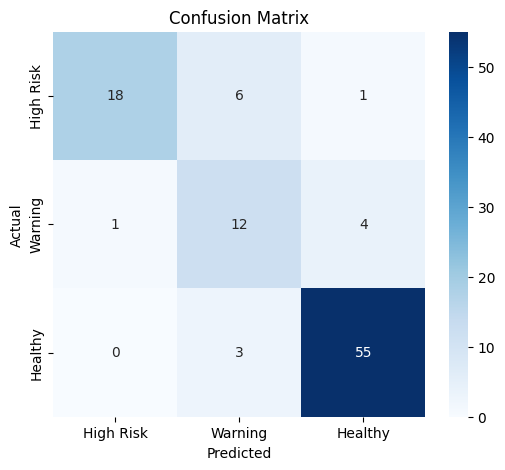

In [79]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize classifier with tuned settings from earlier (if you want)
clf = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Fit on training data
clf.fit(X_train_scaled, y_train_class)

# Predict on test
y_pred_class = clf.predict(X_test_scaled)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test_class, y_pred_class, target_names=["High Risk", "Warning", "Healthy"]))

# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["High Risk", "Warning", "Healthy"],
            yticklabels=["High Risk", "Warning", "Healthy"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Healthy class is very well predicted: Precision and recall both are ~0.93+

High Risk class has high precision (0.95) – this means if the model says it's risky, it's likely correct (important in safety contexts).

Warning class is the weakest: Precision is 0.57, recall 0.71 — some confusion with both “high risk” and “healthy”.

This is expected, since “Warning” is a fuzzy zone. In real-world settings too, borderline cases are hardest to classify.

From the matrix:

18/25 High Risk engines were correctly caught

Only 1 Healthy engine misclassified as Warning (that's good!)

Warning engines are often confused with both High Risk and Healthy, which reflects real-world ambiguity.

I’ve built a dual-model system. The regression model estimates the exact Remaining Useful Life, while the classification model categorizes engines into risk buckets. This enables faster decision-making for field engineers and better preventive maintenance planning.

Now I am going to use SHAP for better interpretability

In [80]:
import shap

# Initialize TreeExplainer
explainer = shap.TreeExplainer(clf)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Confirm shape of SHAP values
print("SHAP values shape:", shap_values.shape)


SHAP values shape: (100, 17, 3)


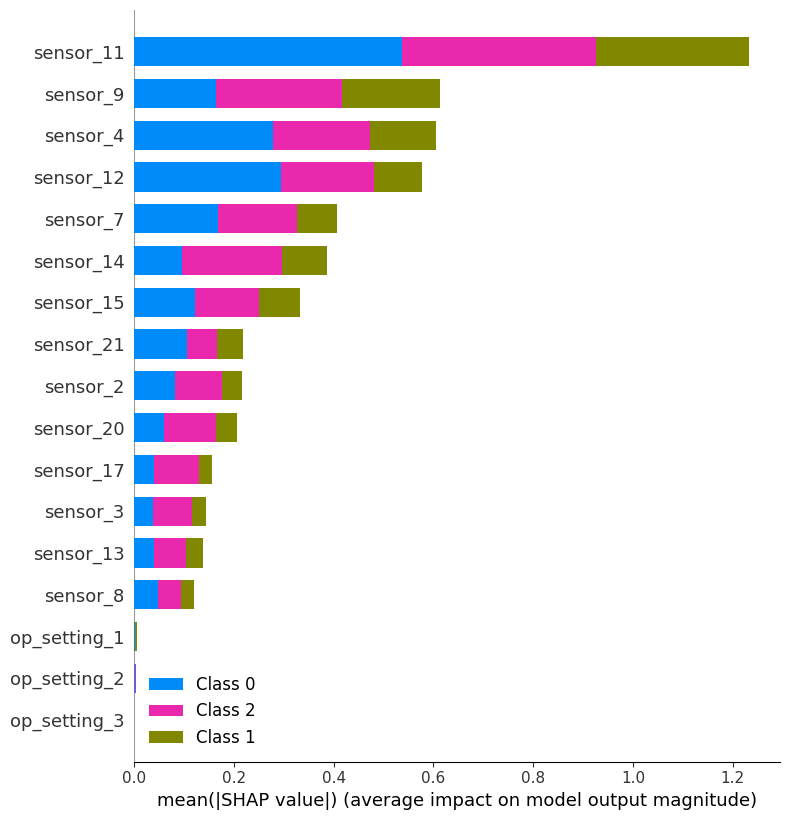

In [81]:
feature_cols = ['op_setting_1', 'op_setting_2', 'op_setting_3',
                'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
                'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13',
                'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

X = test_df[feature_cols]


# Full SHAP summary plot with correct feature names
shap.summary_plot(shap_values, X, plot_type='bar', feature_names=feature_cols)




Most Important Features (Top Influencers)

These features have the highest average SHAP value, which means the model depends on them heavily across all predictions:

Rank	Feature	Key Takeaway

1️⃣	sensor_11	🧠 Most influential sensor across all classes (high impact on decisions).

2️⃣	sensor_9	Strong signal, often used to distinguish classes.

3️⃣	sensor_4	High contribution, especially for predicting "Warning" and "Healthy".

4️⃣	sensor_12	Plays a role in differentiating all 3 classes.

5️⃣	sensor_7	Influences risk classification, but less than above sensors.

These top 5 sensors are the core of your predictive power.

Least Influential Features

op_setting_1, op_setting_2, op_setting_3 have almost zero impact

sensor_8, sensor_13, sensor_3 → Very little contribution

